In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv


In [2]:
# importing a few more libraries
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway, shapiro, levene, chi2_contingency, ttest_1samp, kruskal

## **Problem Statement**
Our dataset contains shopping information from 10 different shopping malls between 2021 and 2023. Data has been gathered from various age groups and genders to provide a comprehensive view of shopping habits in Istanbul. The dataset includes essential information such as invoice numbers, customer IDs, age, gender, payment methods, product categories, quantity, price, order dates, and shopping mall locations.
We want to explore the dataset and discover the fascinating world of Istanbul shopping!

In [3]:
# Importing the dataset
df = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv')
# Peeking a look
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


## **Analysing basic metrics of the dataset**

In [4]:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


* There are 10 features and 99457 records.
* There are 3 numerical features and 7 object type features.

In [5]:
# Checking number of unique entries 
df.nunique()

invoice_no        99457
customer_id       99457
gender                2
age                  52
category              8
quantity              5
price                40
payment_method        3
invoice_date        797
shopping_mall        10
dtype: int64

In [6]:
# Converting gender, category and payment method into categorical datatype
temp = ['gender','category','payment_method']
for i in temp:
    df[i] = df[i].astype('category')

# Converting invoice date to datetime datatype
df['invoice_date'] = df['invoice_date'].astype('datetime64')

In [7]:
# Checking for missing values
df.isna().sum()

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64

There are no missing values in our dataset.

In [8]:
# Statistical summary (numerical features)
df.describe()

,age,quantity,price
count,99457.000000,99457.000000,99457.000000
mean,43.427089,3.003429,689.256321
std,14.990054,1.413025,941.184567
min,18.000000,1.000000,5.230000
25%,30.000000,2.000000,45.450000
50%,43.000000,3.000000,203.300000
75%,56.000000,4.000000,1200.320000
max,69.000000,5.000000,5250.000000


We can see mean, median, minimum and maximum values of age, quantity and price.
* Range of ages - 18 to 69
* Range of quantity - 1 to 5
* Range of price - 5.23 TL to 5250 TL.

In [9]:
# Statistical summary (categorical features)
df.describe(include = 'category')

,gender,category,payment_method
count,99457,99457,99457
unique,2,8,3
top,Female,Clothing,Cash
freq,59482,34487,44447


We can see most frequent entries and their frequencies for gender, category and payment_method.<br>
* Female is more frequently observed gender compared to male.
* Clothing is the most frequently observed category.
* Cash is the most common payment method.

In [10]:
df.describe(include = 'object')

,invoice_no,customer_id,shopping_mall
count,99457,99457,99457
unique,99457,99457,10
top,I138884,C241288,Mall of Istanbul
freq,1,1,19943


We can see the most frequent occurring values and their frequencies for invoice_date and shopping_mall features.
* Most frequent invoice date is 24/11/2021.
* Most frequently observed mall is "Mall of Istanbul".

## **Creating new features**

In [11]:
# Extracting year and month from invoice date
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month
df.head(3)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,year,month
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-05-08,Kanyon,2022,5
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,2021,12
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-09-11,Metrocity,2021,9


## **Outlier detection and treatment**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   invoice_no      99457 non-null  object        
 1   customer_id     99457 non-null  object        
 2   gender          99457 non-null  category      
 3   age             99457 non-null  int64         
 4   category        99457 non-null  category      
 5   quantity        99457 non-null  int64         
 6   price           99457 non-null  float64       
 7   payment_method  99457 non-null  category      
 8   invoice_date    99457 non-null  datetime64[ns]
 9   shopping_mall   99457 non-null  object        
 10  year            99457 non-null  int64         
 11  month           99457 non-null  int64         
dtypes: category(3), datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 7.1+ MB


In [13]:
# Finding outliers in numerical features
temp = ['age', 'quantity', 'price']
for i in temp:
    percentile_25 = np.percentile(df[i],25)
    percentile_75 = np.percentile(df[i],75)
    iqr = (percentile_75 - percentile_25)
    upper = percentile_75 + iqr*1.5
    lower = min(0, percentile_25 - iqr*1.5)
    number_of_outliers = ((df[i]<lower) | (df[i]>upper)).sum()
    print('Number of outliers in feature {x} is {y}'.format(x=i, y=number_of_outliers))

Number of outliers in feature age is 0
Number of outliers in feature quantity is 0
Number of outliers in feature price is 5024


We observe 5024 outliers in price.
Let's clip the values greater than our upper limit to the upper limit. Similarly for values lower than lower limit.

In [14]:
temp = ['price']
for i in temp:
    percentile_25 = np.percentile(df[i],25)
    percentile_75 = np.percentile(df[i],75)
    iqr = (percentile_75 - percentile_25)
    upper = percentile_75 + iqr*1.5
    lower = min(0, percentile_25 - iqr*1.5)
    df[i].loc[df[i]>upper] = upper
    df[i].loc[df[i]<lower] = lower

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
# Checking the number of outliers after treatment
temp = ['price']
for i in temp:
    percentile_25 = np.percentile(df[i],25)
    percentile_75 = np.percentile(df[i],75)
    iqr = (percentile_75 - percentile_25)
    upper = percentile_75 + iqr*1.5
    lower = min(0, percentile_25 - iqr*1.5)
    number_of_outliers = ((df[i]<lower) | (df[i]>upper)).sum()
    print('Number of outliers in feature {x} is {y}'.format(x=i, y=number_of_outliers))

Number of outliers in feature price is 0


Outliers in 'price' have been treated.

## **Visual Analysis**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`

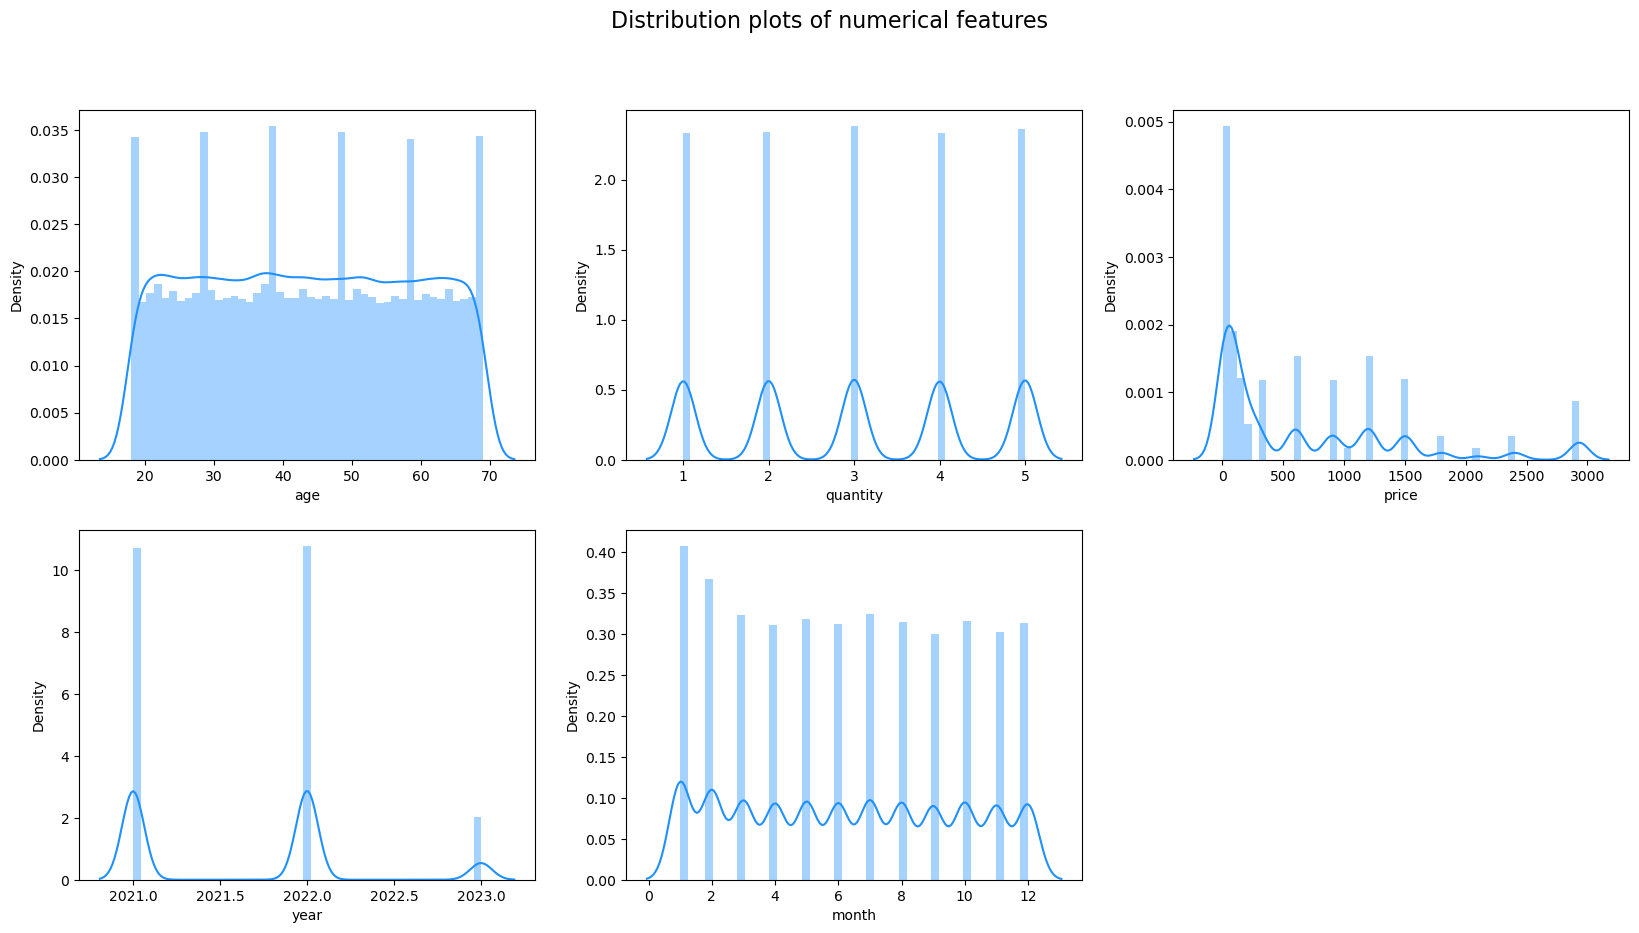

In [18]:
# Creating distribution plots for numerical features
temp = ['age','quantity','price','year', 'month']
plt.figure(figsize=(20,10))
x=1
for i in temp:
    plt.subplot(2,3,x)
    sns.distplot(x=df[i], color='dodgerblue')
    plt.xlabel(i)
    x+=1
plt.suptitle('Distribution plots of numerical features', fontsize=16)
plt.xticks()
plt.show()

Observations-
* All ages have similar probability of occurring.
* All quantities have similar probability of occurring.
* Prices less than 250 TL have a much higher probability of occurring than prices greater than 250 TL.
* There are only a few records of year 2023.
* There are more records of months 1 and 2 (January and February) compared to other months.

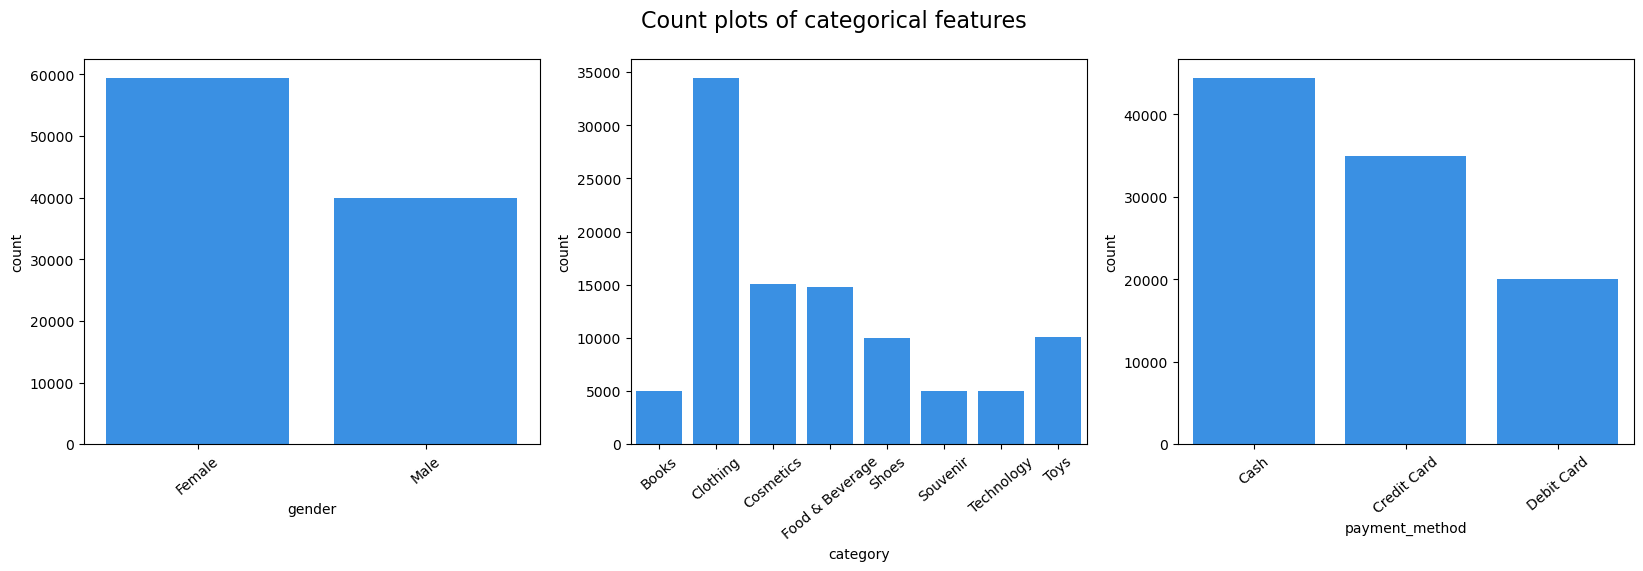

In [17]:
# Count plots of categorical features
temp = ['gender','category','payment_method']
plt.figure(figsize=(20,5))
x=1
for i in temp:
    plt.subplot(1,3,x)
    sns.countplot(x=df[i], color = 'dodgerblue')
    x+=1
    plt.xticks(rotation = 40)
plt.suptitle('Count plots of categorical features', fontsize=16)
plt.show()

Observations-
* Females are more frequent customers than males.
* Clothing is the most common category.
* Cash is the most common payment method.

In [18]:
df.head(3)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,year,month
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-05-08,Kanyon,2022,5
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,2021,12
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-09-11,Metrocity,2021,9


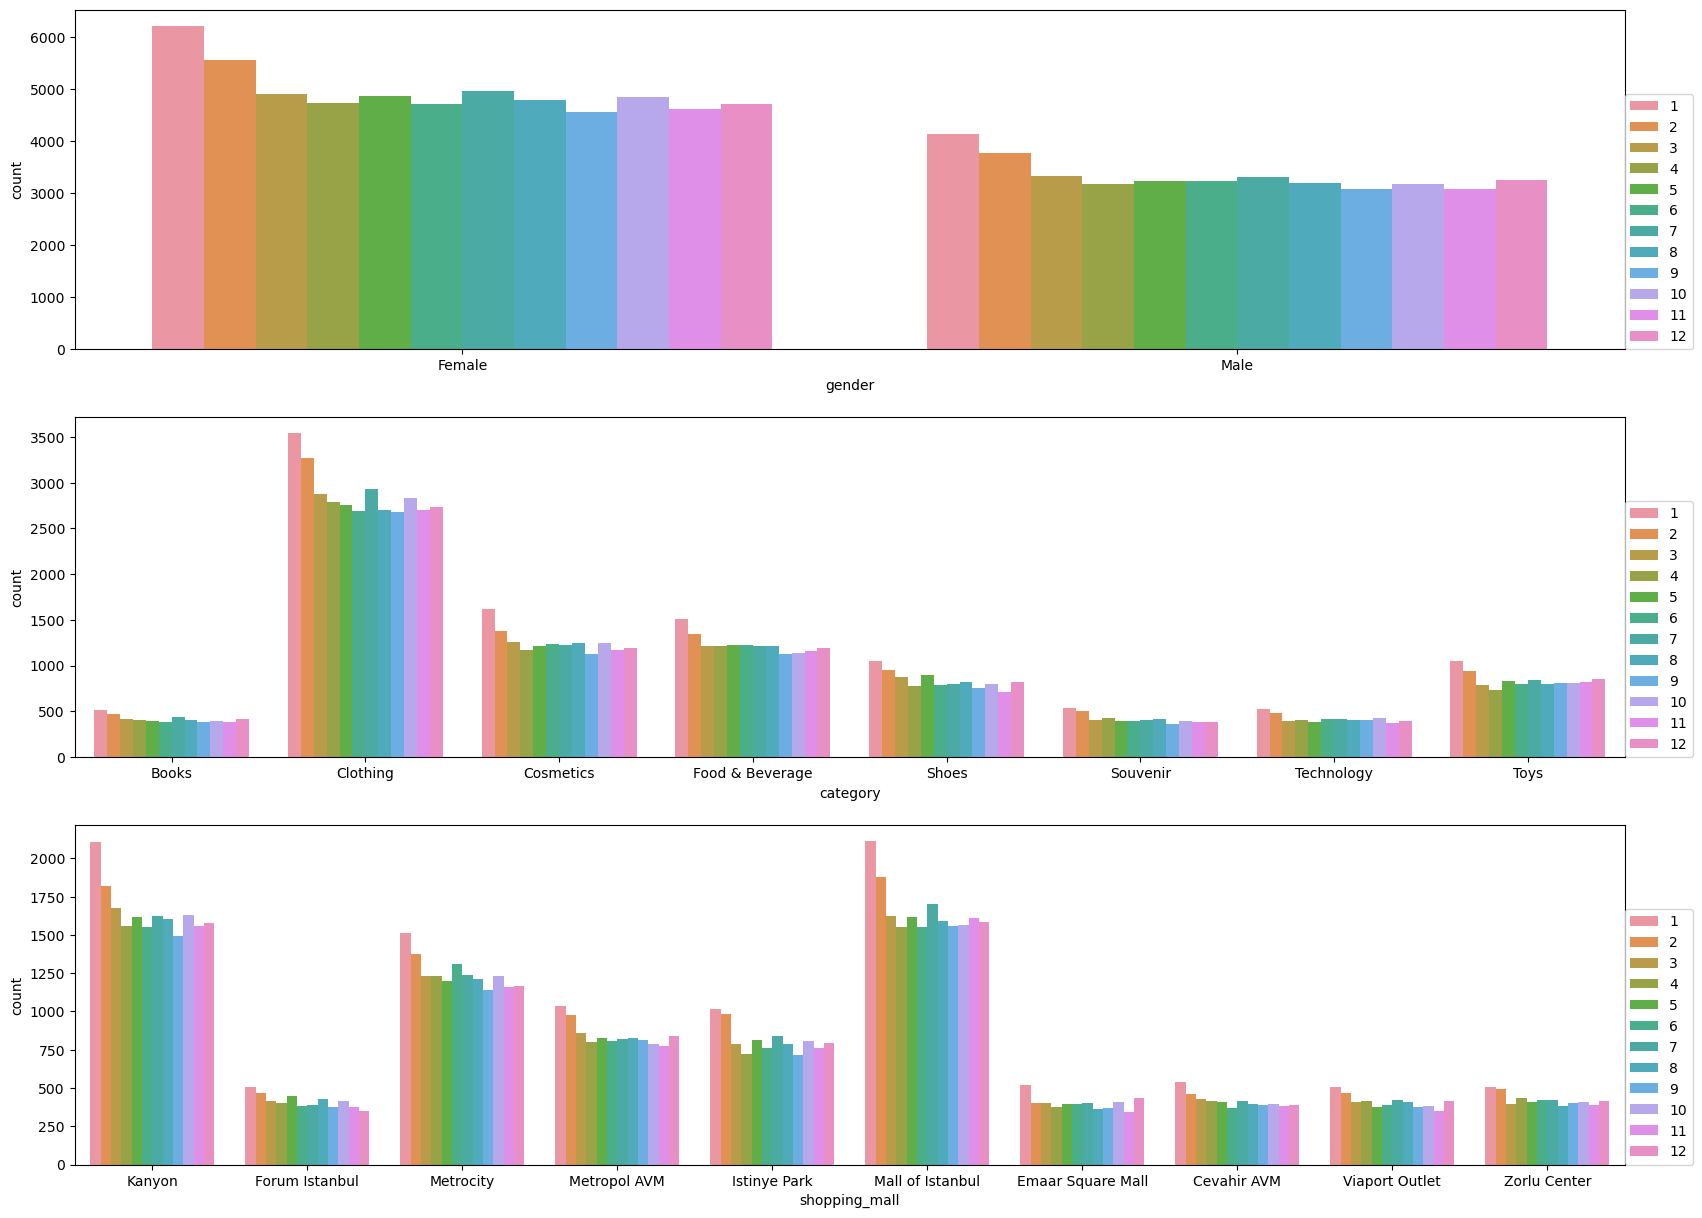

In [19]:
# Bivariate plots of some features vs month
temp = ['gender', 'category', 'shopping_mall']
plt.figure(figsize=(20,15))
x=1
for i in temp:
    plt.subplot(3,1,x)
    x += 1
    sns.countplot(data = df, x = i, hue = 'month')
    plt.legend(loc=(1,0))
plt.show()

Observations-
- We see that sales are generally higher in initial months of the year (January and February).
- Clothing, cosmetics, food-and-beverge, shoes and toys are more frequently purchased categories than others.
- Mall of Istanbul, Kanyon and Metrocity see more purchases than other malls.

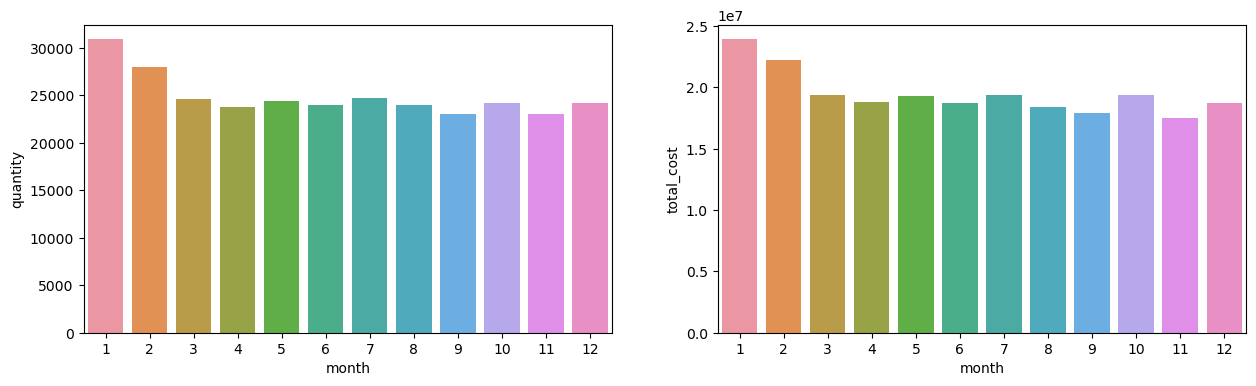

In [20]:
# Bivariate plots of quantity and price vs month
df['total_cost'] = df['quantity']*df['price']
temp = ['quantity', 'total_cost']
plt.figure(figsize=(15,4))
x=1
for i in temp:
    plt.subplot(1,2,x)
    x+=1
    sns.barplot(data = df, x = 'month',y = i, estimator = 'sum', errorbar=None)
plt.show()

Quantity purchased in different months and total cost of those purchases have a similar trend as we move from January to December.

Let's divide age into bins. Then we can see count of customers in each bin and the relation between age and category.

In [21]:
df['age'].min(), df['age'].max()

(18, 69)

In [22]:
df['age_binned'] = pd.cut(df['age'], bins = [18,25,35,45,55,65,70])
df.head(3)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,year,month,total_cost,age_binned
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-05-08,Kanyon,2022,5,7502.00,"(25, 35]"
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,2021,12,5401.53,"(18, 25]"
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-09-11,Metrocity,2021,9,300.08,"(18, 25]"


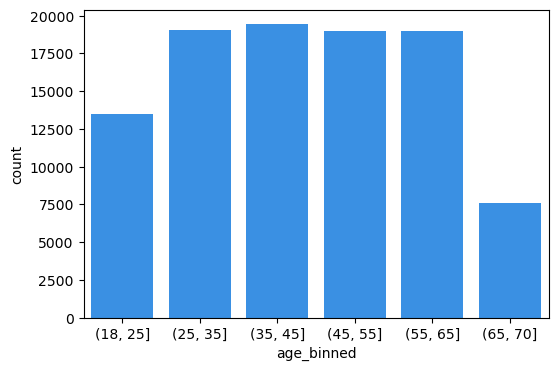

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['age_binned'], color = 'dodgerblue')
plt.show()

The number of customers of all age bins seem to be similar.

In [24]:
pd.crosstab(df['age_binned'], df['category'], normalize = 'columns', margins=True)

category,Books,Clothing,Cosmetics,Food & Beverage,Shoes,Souvenir,Technology,Toys,All
age_binned,,,,,,,,,
"(18, 25]",0.139897,0.138619,0.135469,0.139703,0.139815,0.134942,0.134909,0.141963,0.138455
"(25, 35]",0.188718,0.195443,0.195212,0.194550,0.195478,0.198323,0.196046,0.196751,0.195251
"(35, 45]",0.192821,0.198310,0.195954,0.202967,0.195275,0.204253,0.211942,0.198971,0.199113
"(45, 55]",0.201231,0.195296,0.199730,0.191307,0.198114,0.182989,0.191971,0.191706,0.194810
"(55, 65]",0.198769,0.194468,0.196763,0.194205,0.195275,0.204662,0.189525,0.189285,0.194810
"(65, 70]",0.078564,0.077864,0.076871,0.077268,0.076042,0.074831,0.075606,0.081324,0.077561


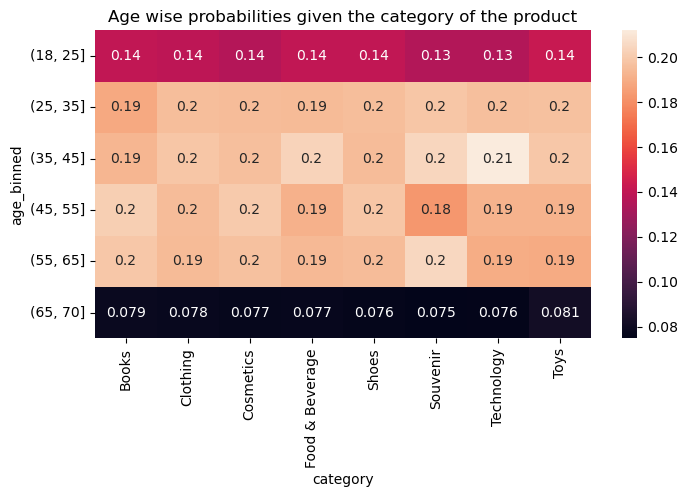

In [25]:
plt.figure(figsize=(8,4))
sns.heatmap(pd.crosstab(df['age_binned'], df['category'], normalize = 'columns'), annot=True)
plt.title('Age wise probabilities given the category of the product')
plt.show()

Observations-
- Probability of purchase of food & beverage is highest for age group 35-45.
- Probability of purchase for a technology product is highest for age group 35-45.
- Probability of purchase of a souvenir is highest for age group 55-65.

In [26]:
df.head(3)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,year,month,total_cost,age_binned
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-05-08,Kanyon,2022,5,7502.00,"(25, 35]"
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,2021,12,5401.53,"(18, 25]"
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-09-11,Metrocity,2021,9,300.08,"(18, 25]"


Let's plot shopping mall vs category.

In [27]:
pd.crosstab(df['shopping_mall'], df['category'], normalize = 'columns')

category,Books,Clothing,Cosmetics,Food & Beverage,Shoes,Souvenir,Technology,Toys
shopping_mall,,,,,,,,
Cevahir AVM,0.051797,0.050135,0.048486,0.052247,0.048834,0.048010,0.051241,0.050957
Emaar Square Mall,0.047380,0.047873,0.050341,0.046833,0.049631,0.049410,0.052642,0.046000
Forum Istanbul,0.050592,0.050135,0.051004,0.048186,0.045645,0.052210,0.046837,0.052642
Istinye Park,0.092752,0.097225,0.096575,0.100839,0.099761,0.103021,0.097478,0.100625
Kanyon,0.203373,0.198336,0.200238,0.196873,0.201017,0.207441,0.199560,0.196986
Mall of Istanbul,0.205782,0.200742,0.202027,0.200122,0.201615,0.189638,0.203563,0.198275
Metrocity,0.150974,0.152753,0.150030,0.151868,0.145206,0.147630,0.154524,0.150193
Metropol AVM,0.095563,0.102212,0.102073,0.102666,0.107036,0.106221,0.092874,0.102409
Viaport Outlet,0.049388,0.049526,0.048619,0.049607,0.049532,0.045009,0.051241,0.051056


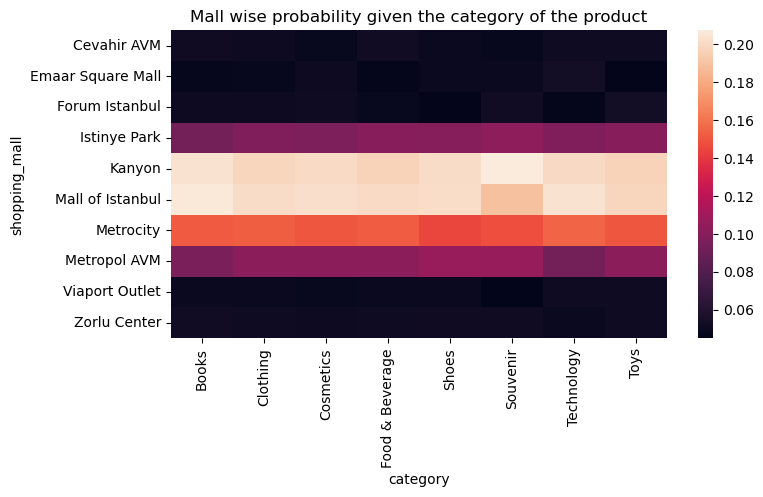

In [28]:
plt.figure(figsize=(8,4))
sns.heatmap(pd.crosstab(df['shopping_mall'], df['category'], normalize = 'columns'))
plt.title('Mall wise probability given the category of the product')
plt.show()

Observations-
- Probability of purchase of souvenir is highest for Kanyon mall as compared to other malls.
- Probability of purchase of books is highest for Mall of Istanbul.
- Probability of purchase of a technology product is highest for Mall of Istanbul.

Let's plot age-bins vs shopping mall

In [29]:
pd.crosstab(df['shopping_mall'], df['age_binned'], normalize='columns')

age_binned,"(18, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 70]"
shopping_mall,,,,,,
Cevahir AVM,0.048021,0.054725,0.049547,0.048854,0.050379,0.047418
Emaar Square Mall,0.046245,0.048691,0.050268,0.046277,0.050326,0.047550
Forum Istanbul,0.050462,0.050947,0.045740,0.049905,0.050379,0.052569
Istinye Park,0.098631,0.099848,0.097088,0.099127,0.095761,0.101704
Kanyon,0.201110,0.193872,0.202562,0.200989,0.198780,0.199974
Mall of Istanbul,0.204514,0.198017,0.199372,0.199516,0.202829,0.200766
Metrocity,0.147392,0.152526,0.150391,0.150820,0.153345,0.147801
Metropol AVM,0.104033,0.102366,0.104651,0.101020,0.097970,0.104742
Viaport Outlet,0.049575,0.049478,0.050319,0.048433,0.049853,0.048078


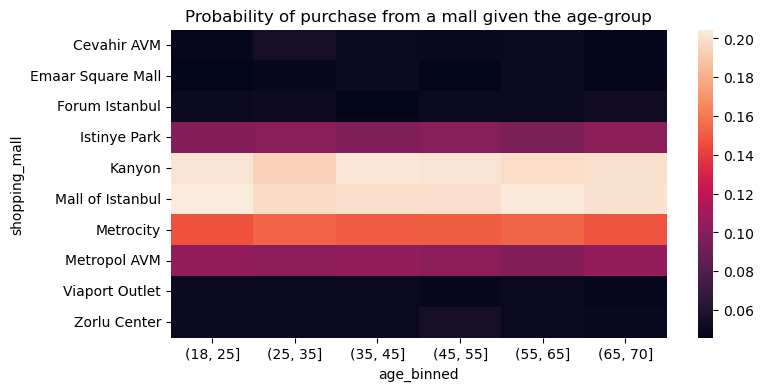

In [30]:
plt.figure(figsize=(8,4))
sns.heatmap(pd.crosstab(df['shopping_mall'], df['age_binned'], normalize='columns'))
plt.title('Probability of purchase from a mall given the age-group')
plt.show()

Observations-
- Someone of age group 18-25 is most likely to purchse from Mall of Istanbul.
- Age group 35-45 is most likely to purchase from Kanyon.
- Age 55-65 is most likely to pruchse from Mall of Istanbul.

Let's plot gender vs shopping mall

In [31]:
pd.crosstab(df['shopping_mall'], df['gender'], normalize = 'columns')

gender,Female,Male
shopping_mall,,
Cevahir AVM,0.049427,0.051307
Emaar Square Mall,0.047779,0.049256
Forum Istanbul,0.050704,0.048305
Istinye Park,0.098753,0.097736
Kanyon,0.200161,0.198049
Mall of Istanbul,0.200094,0.201151
Metrocity,0.150314,0.151845
Metropol AVM,0.103292,0.100488
Viaport Outlet,0.049578,0.049156


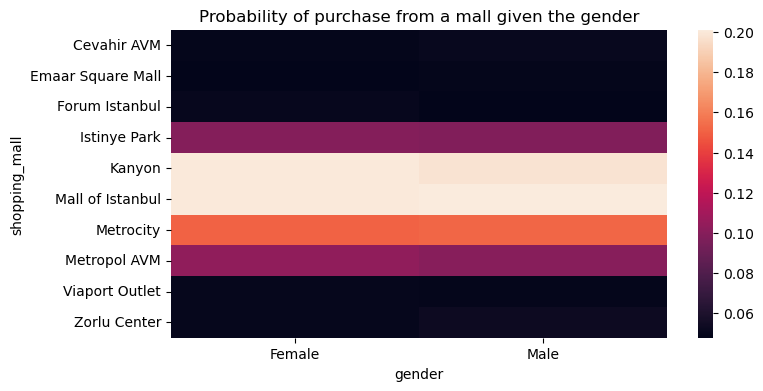

In [32]:
plt.figure(figsize=(8,4))
sns.heatmap(pd.crosstab(df['shopping_mall'], df['gender'], normalize='columns'))
plt.title('Probability of purchase from a mall given the gender')
plt.show()

- Males are most likely to purchase from Mall of Istanbul.

## **Hypothesis Testing**

### Claims-
1. Mean price of products is greater than 500 TL.
2. Median purchases in Jan and Feb is higher than other months.
3. Mean frequency of purchase by females per month higher than males.
4. Clothing is the most frequently bought product category.
5. Cash is the most frequently used payment method.
6. Some malls observe more purchases than others.
8. Number of purchases of food & beverage items is different for different age groups.
9. Number of purchases of souvenir products is different for different age groups.
10. Number of purchases of technology products is different for different age groups.
11. Kanyon sells more souvenirs than Mall of Istanbul.
12. Mall of Istanbul sells more books than Kanyon.
13. Mall of Istanbul sells more technology products than Kanyon.

Let's test all the claims one by one. <br>
#### Claim 1 - Mean price of a product is greater than 500 TL.<br>
Null hypothesis H(0) - Mean price <= 500 <br>
Alternate hypothesis H(a) - Mean price > 500

In [33]:
# Separating price data
temp = df['price']
# Using ttest_1samp to test the claim
t_stat, p_value = ttest_1samp(temp,500, alternative = 'greater')
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Mean > 500 TL')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Mean <= 500 TL')

p-value = 0.0
p-value is less than our significance level.
We can reject the null hypothesis
Mean > 500 TL


Claim 1 is true.

#### Claim 2 - Mean number of purchases in Jan and Feb is higher than other months.<br>
Null hypothesis H(0) - Median purchase count is same for all months <br>
Alternate hypothesis H(a) - Median purchase count is different for different months.

In [34]:
# Separating data for all months
grouped = df.groupby(['year','month']).agg(total_purchases = ('invoice_no','count')).reset_index()
m = [grouped.loc[grouped['month']==i,'total_purchases'] for i in range(1,13)]
print(m[0],'\n',m[1])

0     3771
12    3842
24    2745
Name: total_purchases, dtype: int64 
 1     3402
13    3445
25    2488
Name: total_purchases, dtype: int64


In [35]:
# Comparing median of all months using kruskal-wallis test
t_stat, p_value = kruskal(m[0],m[1],m[2],m[3],m[4],m[5],m[6],m[7],m[8],m[9],m[10],m[11])
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Medians are different.')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Medians are same.')

p-value = 0.8837698156555098
p-value is greater than our significance level.
We can't reject the null hypothesis
Medians are same.


Claim 2 is false.

#### Claim 3 - Mean frequency of purchase by females per month higher than males.<br>
Null hypothesis H(0) - Mean count of purchase is same for male and female. <br>
Alternate hypothesis H(a) - Mean count of purchase is greater for femles.

In [36]:
# Separating male and female purchase counts per month
grouped = df.groupby(['year', 'month','gender']).agg(monthly_freq = ('invoice_no', 'count')).reset_index()
male_freq = grouped.loc[grouped['gender']=='Male','monthly_freq']
female_freq = grouped.loc[grouped['gender']=='Female','monthly_freq']

In [37]:
# Comparing them using ttest_ind
t_stat, p_value = ttest_ind(male_freq, female_freq, alternative = 'less')
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Mean frequency of purchase is greater for females.')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Mean frequency of purchase is same for both.')

p-value = 0.0025425070606410523
p-value is less than our significance level.
We can reject the null hypothesis
Mean frequency of purchase is greater for females.


Claim 3 is true.

#### Claim 4 - Clothing is the most frequently bought product category.<br>
Null hypothesis H(0) - Mean frequency of purchase of all categories are same. <br>
Alternate hypothesis H(a) - Mean frequency of purchase of categories differ from each other.

In [38]:
# Separating monthly quantity for each category
grouped = df.groupby(['year','month','category']).agg(items_bought = ('quantity','sum')).reset_index()
c = [grouped.loc[grouped['category']==i,'items_bought'] for i in df['category'].unique()]

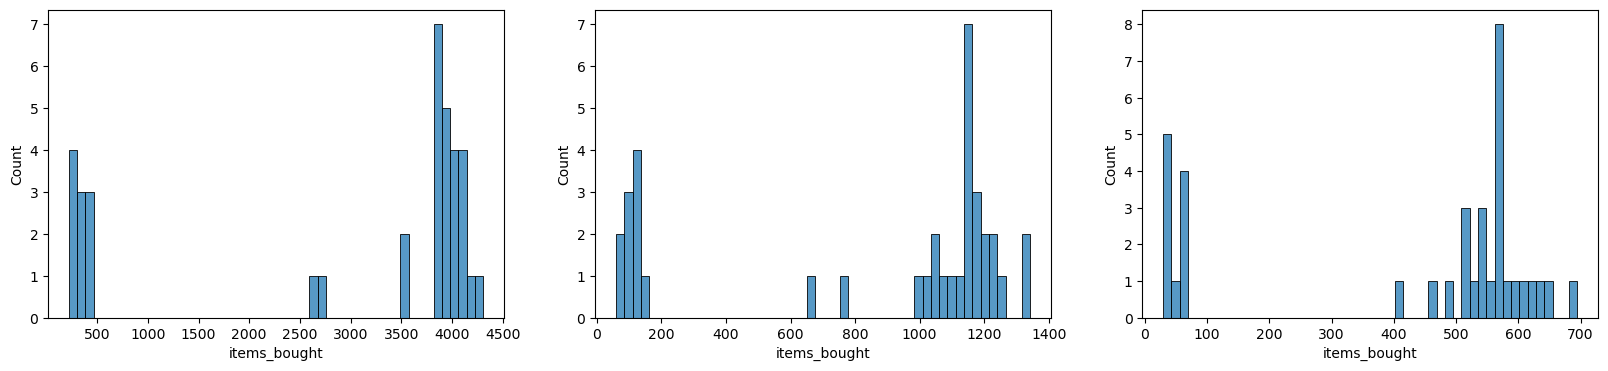

In [39]:
# Checking if distributions are normal (gaussian)
plt.figure(figsize=(20,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.histplot(c[i], bins = 50)
plt.show()

The distributions don't seem to be normal. We can't use ANOVA. We'll use Kruskal-Wallis test.

In [40]:
t_stat, p_value = kruskal(c[0],c[1],c[2],c[3],c[4],c[5],c[6],c[7])
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Medians are different.')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Medians are same.')

p-value = 4.498086493209725e-17
p-value is less than our significance level.
We can reject the null hypothesis
Medians are different.


Claim 4 is true.

#### Claim 5 - Cash is the most frequently used payment method.<br>
Null hypothesis H(0) - Mean frequency of purchase using all payment methods is same. <br>
Alternate hypothesis H(a) - Mean frequency of purchase using different payment methods is different.

In [41]:
# Sepearating monthly usage frequency for different payment methods
grouped = df.groupby(['year', 'month', 'payment_method']).agg(frequency = ('invoice_no', 'count')).reset_index()
pm = [grouped.loc[grouped['payment_method']==i, 'frequency'] for i in df['payment_method'].unique()]

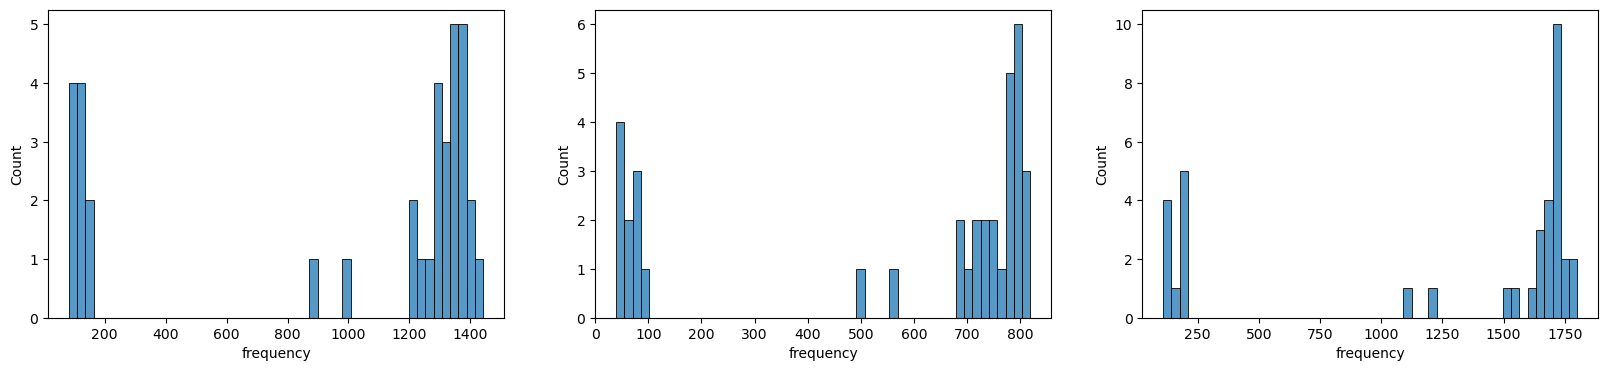

In [42]:
# Checking if the distributions are normal (gaussian)
plt.figure(figsize=(20,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.histplot(pm[i], bins=50)
plt.show()

The data doesn't appear gaussian. We will use kruskal-wallis test.

In [43]:
t_stat, p_value = kruskal(pm[0],pm[1],pm[2])
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Medians are different.')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Medians are same.')

p-value = 1.705202400580592e-07
p-value is less than our significance level.
We can reject the null hypothesis
Medians are different.


Claim 5 is true.

#### Claim 6 - Some malls observe more purchases than others.<br>
Null hypothesis H(0) - Mean frequency of purchase at all malls is same. <br>
Alternate hypothesis H(a) - Mean frequency of purchase at diffent malls is different.

In [44]:
# Separating monthly purchase frequency for all malls
grouped = df.groupby(['year','month','shopping_mall']).agg(monthly_freq = ('invoice_no','count')).reset_index()
malls = [grouped.loc[grouped['shopping_mall']==i, 'monthly_freq'] for i in df['shopping_mall'].unique()]

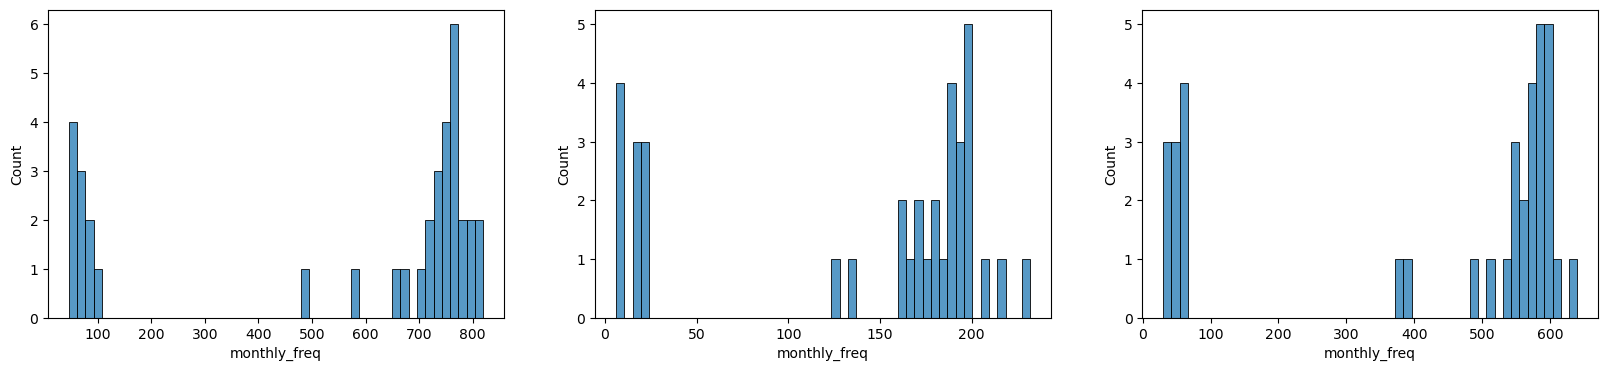

In [45]:
# Checking if the distributions are normal
plt.figure(figsize=(20,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.histplot(malls[i], bins=50)
plt.show()

In [46]:
# Performing shapriro test to confirm gaussian nature
print(shapiro(malls[0]))
print(shapiro(malls[1]))
print(shapiro(malls[2]))

ShapiroResult(statistic=0.6947412490844727, pvalue=2.341420497486979e-07)
ShapiroResult(statistic=0.7538285255432129, pvalue=2.226605374744395e-06)
ShapiroResult(statistic=0.7032335996627808, pvalue=3.1812896850169636e-07)


Based on the graphs and shapiro tests we can say the distributions are not gaussian. We will use kruskal-wallis test to check medians instead of men.

In [47]:
t_stat, p_value = kruskal(malls[0],malls[1],malls[2],malls[3],malls[4],malls[5],malls[6],malls[7],malls[8],malls[9])
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Medians are different.')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Medians are same.')

p-value = 2.3789356056396905e-19
p-value is less than our significance level.
We can reject the null hypothesis
Medians are different.


Claim 6 is true.

#### Claim 7 - Number of purchases of food & beverage items is different for different age groups.<br>
Null hypothesis H(0) - Mean frequency of purchase of food and beverages is same for all age groups. <br>
Alternate hypothesis H(a) - Mean frequency of purchase of food and beverages is different for different age groups.

In [48]:
# Separating frequency of purchase of food and beverages by different age groups
grouped = df.groupby(['year','month','category','age_binned']).agg(monthly_freq = ('invoice_no','count')).reset_index()
age = [grouped.loc[(grouped['category']=='Food & Beverage') & (grouped['age_binned']==i), 'monthly_freq'] for i in df['age_binned'].unique()]

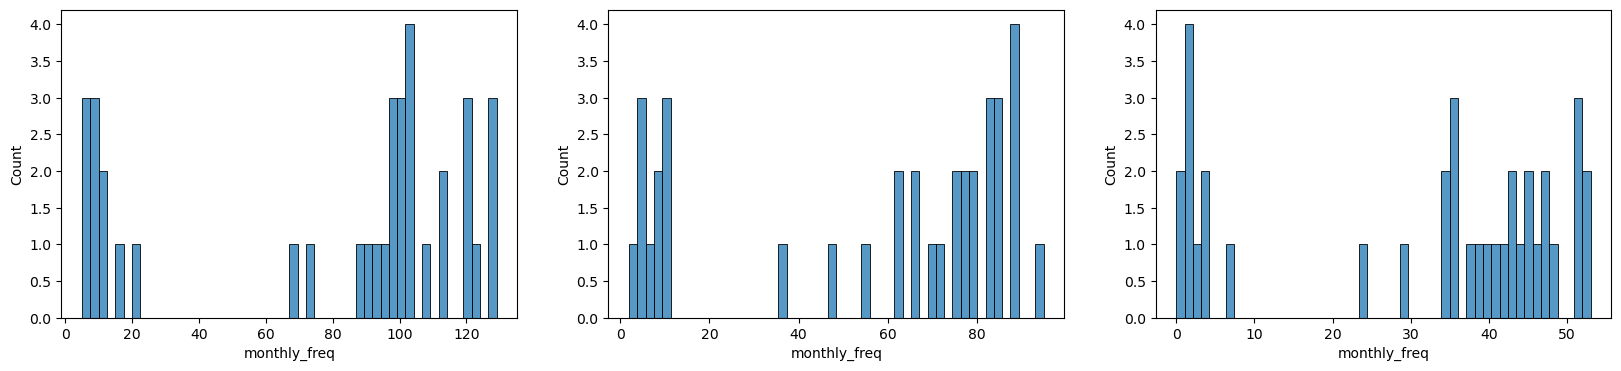

In [49]:
# Checking if the distributions are normal
plt.figure(figsize=(20,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.histplot(age[i], bins=50)
plt.show()

The distributions don't appear normal. We will use kruskal-wallis test.

In [50]:
t_stat, p_value = kruskal(age[0],age[1],age[2],age[3],age[4],age[5])
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Medians are different.')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Medians are same.')

p-value = 7.199614453179001e-09
p-value is less than our significance level.
We can reject the null hypothesis
Medians are different.


Claim 7 is true.

#### Claim 8 - Number of purchases of souvenir products is different for different age groups.<br>
Null hypothesis H(0) - Mean frequency of purchase of souvenirs is same for all age groups. <br>
Alternate hypothesis H(a) - Mean frequency of purchase of souvenirs is different for different age groups.

In [51]:
# Separating frequency of purchase of souvenirs by different age groups
grouped = df.groupby(['year','month','category','age_binned']).agg(monthly_freq = ('invoice_no','count')).reset_index()
age_souv = [grouped.loc[(grouped['category']=='Souvenir') & (grouped['age_binned']==i), 'monthly_freq'] for i in df['age_binned'].unique()]

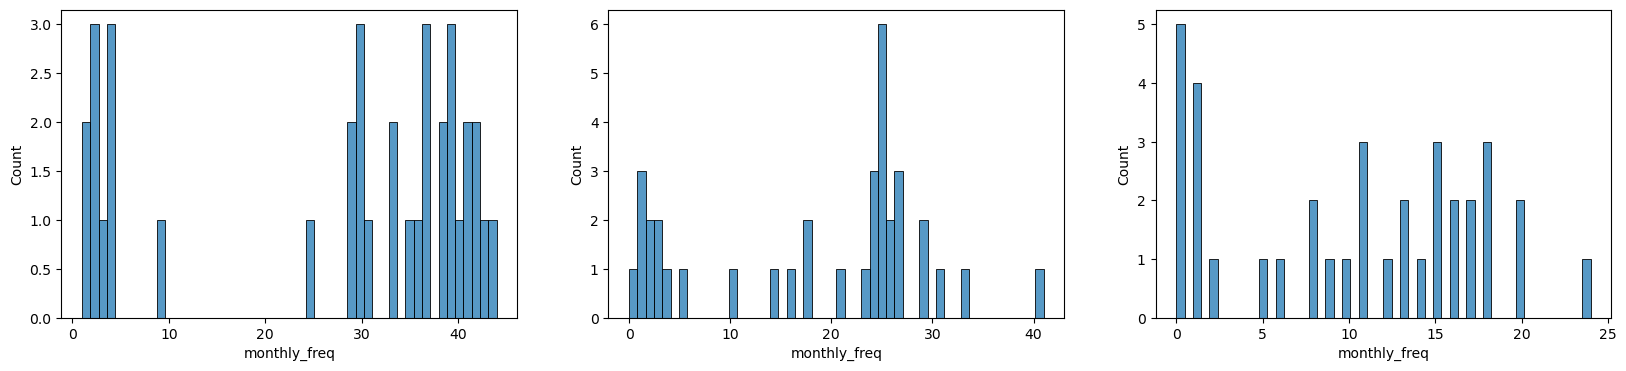

In [52]:
# Checking if the distributions are normal
plt.figure(figsize=(20,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.histplot(age_souv[i], bins=50)
plt.show()

The distributions don't appear normal. We will use kruskal-wallis test.

In [53]:
t_stat, p_value = kruskal(age_souv[0],age_souv[1],age_souv[2],age_souv[3],age_souv[4],age_souv[5])
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Medians are different.')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Medians are same.')

p-value = 3.285050298746921e-08
p-value is less than our significance level.
We can reject the null hypothesis
Medians are different.


Claim 8 is true.

#### Claim 9 - Number of purchases of technology products is different for different age groups.<br>
Null hypothesis H(0) - Mean frequency of purchase of technology products is same for all age groups. <br>
Alternate hypothesis H(a) - Mean frequency of purchase of technology products is different for different age groups.

In [54]:
# Separating frequency of purchase of technology products by different age groups
grouped = df.groupby(['year','month','category','age_binned']).agg(monthly_freq = ('invoice_no','count')).reset_index()
age_tech = [grouped.loc[(grouped['category']=='Technology') & (grouped['age_binned']==i), 'monthly_freq'] for i in df['age_binned'].unique()]

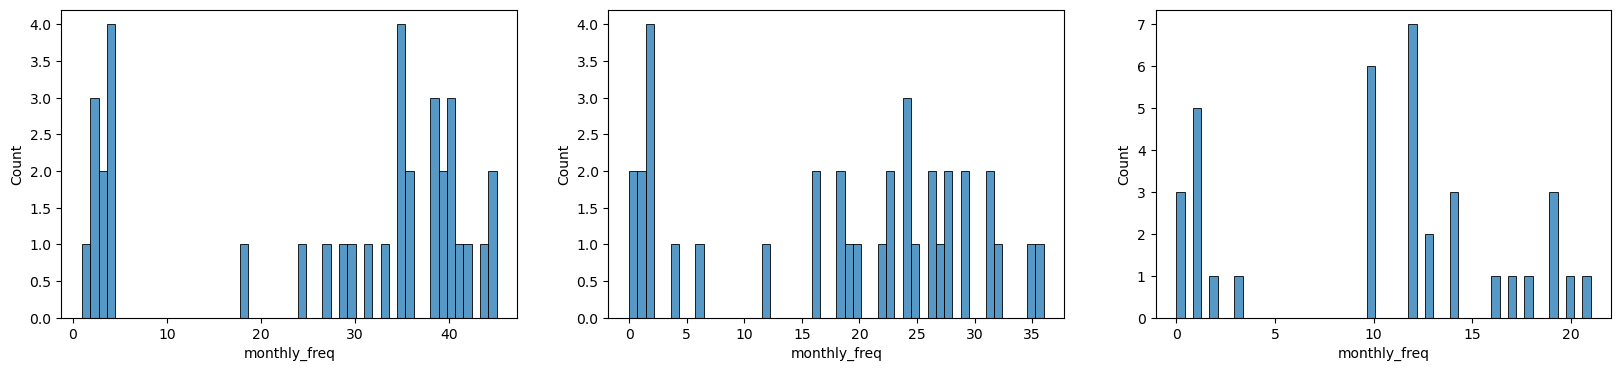

In [55]:
# Checking if the distributions are normal
plt.figure(figsize=(20,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.histplot(age_tech[i], bins=50)
plt.show()

The distributions don't appear normal. We will use kruskal-wallis test.

In [56]:
t_stat, p_value = kruskal(age_tech[0],age_tech[1],age_tech[2],age_tech[3],age_tech[4],age_tech[5])
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Medians are different.')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Medians are same.')

p-value = 8.166881197439152e-08
p-value is less than our significance level.
We can reject the null hypothesis
Medians are different.


Claim 9 is true.

#### Claim 10 - Kanyon sells more souvenirs than Mall of Istanbul.<br>
Null hypothesis H(0) - Mean total purchase of souvenirs is same for both malls. <br>
Alternate hypothesis H(a) - Mean total purchase of souvenirs is greater for Kanyon.

In [57]:
# Separating frequency of purchase of souvenirs by Kanyon and Mall of Istanbul.
grouped = df.groupby(['year','month','category','shopping_mall']).agg(monthly_freq = ('quantity','sum')).reset_index()
kanyon = grouped.loc[(grouped['category']=='Souvenir') & (grouped['shopping_mall']=='Kanyon'), 'monthly_freq']
mall_of_ist = grouped.loc[(grouped['category']=='Souvenir') & (grouped['shopping_mall']=='Mall of Istanbul'), 'monthly_freq']

In [58]:
t_stat, p_value = ttest_ind(kanyon, mall_of_ist, alternative='greater')
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Means are different.')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Means are same.')

p-value = 0.4055304441486605
p-value is greater than our significance level.
We can't reject the null hypothesis
Means are same.


Claim 10 is false.

#### Claim 11 - Mall of Istanbul sells more books than Kanyon.<br>
Null hypothesis H(0) - Mean total purchase of books is same for both malls. <br>
Alternate hypothesis H(a) - Mean total purchase of books is greater for Mall of Istanbul.

In [59]:
# Separating total purchase of books by Kanyon and Mall of Istanbul.
grouped = df.groupby(['year','month','category','shopping_mall']).agg(monthly_freq = ('quantity','sum')).reset_index()
kanyon = grouped.loc[(grouped['category']=='Books') & (grouped['shopping_mall']=='Kanyon'), 'monthly_freq']
mall_of_ist = grouped.loc[(grouped['category']=='Books') & (grouped['shopping_mall']=='Mall of Istanbul'), 'monthly_freq']

In [60]:
t_stat, p_value = ttest_ind(kanyon, mall_of_ist, alternative='less')
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Means are different.')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Means are same.')

p-value = 0.38233540026695345
p-value is greater than our significance level.
We can't reject the null hypothesis
Means are same.


Claim 11 is false.

#### Claim 12 - Mall of Istanbul sells more technology products than Kanyon.<br>
Null hypothesis H(0) - Mean total purchase of technology products is same for both malls. <br>
Alternate hypothesis H(a) - Mean total purchase of technology products is greater for Mall of Istanbul.

In [61]:
# Separating total purchase of books by Kanyon and Mall of Istanbul.
grouped = df.groupby(['year','month','category','shopping_mall']).agg(monthly_freq = ('quantity','sum')).reset_index()
kanyon = grouped.loc[(grouped['category']=='Technology') & (grouped['shopping_mall']=='Kanyon'), 'monthly_freq']
mall_of_ist = grouped.loc[(grouped['category']=='Technology') & (grouped['shopping_mall']=='Mall of Istanbul'), 'monthly_freq']

In [62]:
t_stat, p_value = ttest_ind(kanyon, mall_of_ist, alternative='less')
print('p-value =',p_value)
if p_value < 0.05:
    print('p-value is less than our significance level.\nWe can reject the null hypothesis')
    print('Means are different.')
else:
    print("p-value is greater than our significance level.\nWe can't reject the null hypothesis")
    print('Means are same.')

p-value = 0.48399432116456154
p-value is greater than our significance level.
We can't reject the null hypothesis
Means are same.


Claim 12 is false.

## **Insights**
1. Mean price per product is greater than 500TL.
2. Mean frequency of purchase by females per month is higher than males.
3. Clothing is the most frequently purchased product category.
4. Cash is the most frequently used payment method.
5. Kanyon and Mall of Istanbul observe more purchases than other malls.
6. Purchase of food and beverage is highest for age group 35-45.
7. Purchase of souvenirs is highest for age groups 35-45 and 55-65.
8. Purchase of technology products is highest for age group 35-35.